# Análise do modelo Facebook Prophet para ações
 Autor: Victor Flávio P. Dornelos

## 1. Exploração dos dados

In [28]:
# Bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns


In [29]:
# Baixando o dados 
#df = pd.DataFrame()
#df['HASH11'] = yf.download('HASH11.SA',start='2022-01-01')['Adj Close']
#df.to_csv('hash11.csv')

In [30]:
# Salvando como nome de serie
date_format = lambda dates: datetime.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('hash11.csv', parse_dates=['Date'], index_col='Date',
                      date_parser = date_format, usecols = ['Date', 'HASH11'])
serie = df['HASH11']

/var/folders/f0/r1mlkllj4z14dx7__963964m0000gn/T/ipykernel_1169/3569660717.py:3: FutureWarning:

The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.



In [31]:
# Gráfico das cotações
figura = px.line(title = 'Histórico de cotações de HASH11')

figura.add_scatter(x=serie.index, y=serie)


figura.update_layout(
    xaxis_title='Data',
    yaxis_title='R$',
    title_x=0.5
)

figura.show()

Durante o ano de 2022 é marcado por uma grande queda devido baixa do mercado de criptoativos, ficando estabilizado de início de 2023 até final de Outubro. Posteriormente, é possível verificar uma tendência de alta até atualmente.

In [32]:
# Gerando de composição da série
decomposicao = seasonal_decompose(serie,period= len(serie) // 2)

In [33]:
# Separando a série
trend = decomposicao.trend
sazonal = decomposicao.seasonal
res = decomposicao.resid

In [34]:
# Gráfico de tendência
figura = px.line(title = 'Tendência das cotações de HASH11')

figura.add_scatter(x=trend.index, y=trend)


figura.update_layout(
    xaxis_title='Data',
    yaxis_title='R$',
    title_x=0.5
)

figura.show()

O gráfico de suavização das médias móveis, demonstra que houve uma queda que já foi recuperado e segue em crescimento.

In [35]:
# Gráfico de sazonalidade
figura = px.line(title = 'Sazonalidade de cotações do HASH11')

figura.add_scatter(x=sazonal.index, y=sazonal)


figura.update_layout(
    xaxis_title='Data',
    yaxis_title='R$',
    title_x=0.5
)

figura.show()

Durante o gráfico da série temporal é visto que não tem uma sazonalidade significativa 

## 2. Modelo Facebook Prophet

In [36]:
# Biblioteca necessária
from prophet import Prophet

In [37]:
# Pegando limpo os dados
indice = lambda dates: datetime.datetime.strptime(dates, '%Y-%m-%d')
df_fb = pd.read_csv('hash11.csv')

In [38]:
# Fazendo adequação para o modelo
df_fb = df_fb[['Date', 'HASH11']].rename(columns = {'Date': 'ds', 'HASH11': 'y'})


In [39]:
# Criando o modelo
model = Prophet()
model.fit(df_fb)

15:03:11 - cmdstanpy - INFO - Chain [1] start processing


15:03:11 - cmdstanpy - INFO - Chain [1] done processing


In [40]:
# Realizando previsão com o modelo
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

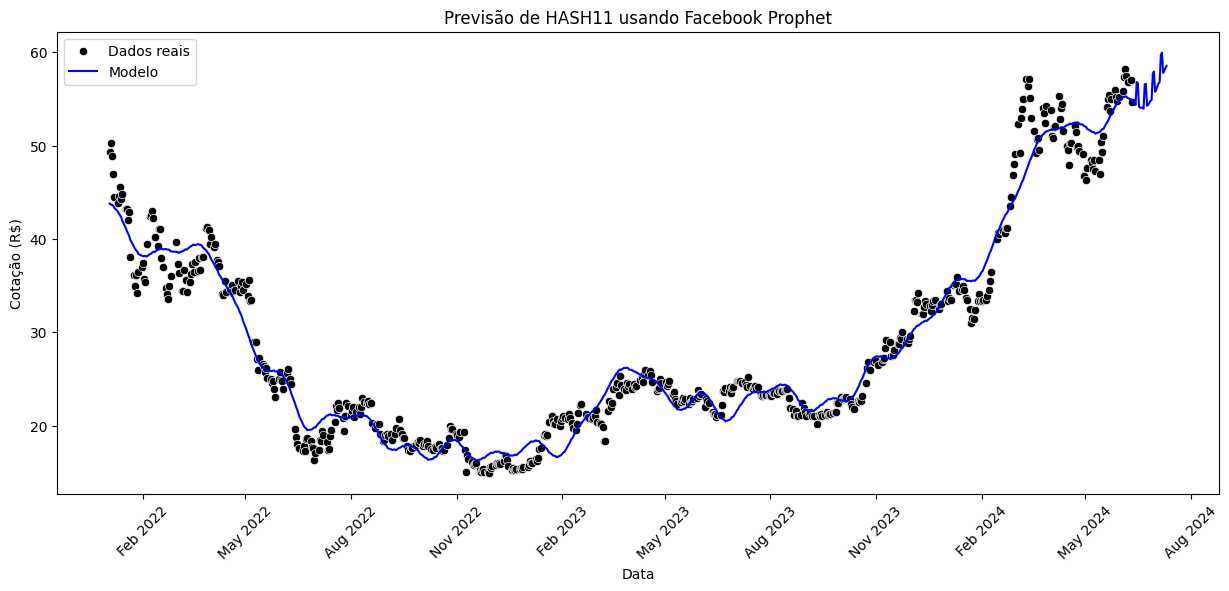

In [41]:
import matplotlib.dates as mdates

df_fb['ds'] = pd.to_datetime(df_fb['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

plt.figure(figsize=(15, 6))
sns.scatterplot(x=df_fb['ds'], y=df_fb['y'], label='Dados reais', color='black')
sns.lineplot(x=forecast['ds'], y=forecast['yhat'], label='Modelo', color='blue')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.xlabel('Data')
plt.ylabel('Cotação (R$)')
plt.title('Previsão de HASH11 usando Facebook Prophet')
plt.legend()
plt.show()

Em geral, o algoritmo conseguiu captar as movimentações do mercado. Apesar de ter alguns casos de superestimação, principalmente, durante os primeiros trimestres de cada ano.

## 3. Avaliação

In [42]:
# Criando série para comparação
pred = model.make_future_dataframe(periods=0)
prev = model.predict(pred)

In [43]:
# Importando bibliotecas para estimar os erros
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [47]:
# Função para criar DF com valores dos erros
def teste_erro(serie,previsao):

    MAD = mean_absolute_error(y_true=serie,y_pred=previsao)
    MAPE = mean_absolute_percentage_error(y_true=serie,y_pred=previsao)
    MSD = mean_squared_error(y_true=serie,y_pred=previsao)

    erros = pd.DataFrame({
        'Metric': ['MAD', 'MAPE', 'MSD'],
        'Value': [MAD, MAPE, MSD]
    })
    
    return erros

In [48]:
teste_erro(df,prev['yhat'])

,Metric,Value
0,MAD,1.683501
1,MAPE,0.060987
2,MSD,4.891084


Com base nas métricas de erro, pode se verificar que o algoritmo conseguiu prever as cotações do ETF HASH11 de forma bastante satisfatória. Principalmente, em razão do MSD ser pequeno, uma vez que ele tem mais peso para os erros com maior magnitudes, ou seja, o modelo teve poucas previsões distantes das observações reais.